<a href="https://colab.research.google.com/github/AnitaTasnim/Industrial-Defect-Detection/blob/main/Untitled94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code trains **PatchCore anomaly detection models** on all **15 MVTec-AD categories** using a **custom EfficientNet-B5 feature extractor** within the Anomalib framework.
It automates **dataset setup, model configuration, training, testing**, and **result visualization** in Kaggle.
Finally, it generates **visual outputs of detected anomalies** and inspects the results directory structure.


# Installation

In [ ]:
!pip uninstall -y anomalib timm pytorch-lightning

!pip install "pytorch-lightning<2.0"
!pip install "anomalib==0.7.0"
!pip install "timm==0.9.12"


Found existing installation: timm 1.0.15
Uninstalling timm-1.0.15:
  Successfully uninstalled timm-1.0.15
Found existing installation: pytorch-lightning 2.5.2
Uninstalling pytorch-lightning-2.5.2:
  Successfully uninstalled pytorch-lightning-2.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 23.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, pprint, yaml, warnings, math, glob, cv2, random, logging

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")

import anomalib
from pytorch_lightning import Trainer, seed_everything
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger

2025-10-08 07:11:28.516316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759907488.710304      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759907488.761520      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

2.6.0+cu124
12.4
90100
True
1
0
Tesla P100-PCIE-16GB


# Model Config  anomalib



In [ ]:
import os
import anomalib

anomalib_root = os.path.dirname(anomalib.__file__)

MODEL_CONFIG_PAIRS = {
    'padim': os.path.join(anomalib_root, 'models/padim/config.yaml'),
    'cflow': os.path.join(anomalib_root, 'models/cflow/config.yaml'),
    'stfpm': os.path.join(anomalib_root, 'models/stfpm/config.yaml'),
    'ganomaly': os.path.join(anomalib_root, 'models/ganomaly/config.yaml'),
    'patchcore': os.path.join(anomalib_root, 'models/patchcore/config.yaml'),
}

MODEL = 'patchcore'
config_path = MODEL_CONFIG_PAIRS[MODEL]
print(config_path)


print(open(config_path, 'r').read())

/usr/local/lib/python3.11/dist-packages/anomalib/models/patchcore/config.yaml
dataset:
  name: mvtec
  format: mvtec
  path: ./datasets/MVTec
  task: segmentation
  category: bottle
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: 224 # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_

# Update Config

In order to train on **MV-Tec** dataset, which is hosted on Kaggle, [HERE](https://www.kaggle.com/datasets/ipythonx/mvtec-ad), we may need to udpate some parameter in the configuration file, for example, `dataset.path`. Also, we may wish to tweak other parameters as well, i.e. `image_size`, `train_batch_size` etc.

In [ ]:
import os
import yaml
import shutil
import gc
import torch
import logging

from anomalib.utils.callbacks import LoadModelCallback

def update_yaml(old_yaml, new_yaml, new_update):
    # Load config gốc
    with open(old_yaml) as f:
        old = yaml.safe_load(f)

    temp = []

    def set_state(old, key, value):
        if isinstance(old, dict):
            for k, v in old.items():
                if k == 'project':
                    temp.append(k)
                if k == key:
                    if temp and k == 'path':
                        continue
                    # Xử lý đặc biệt cho category khi là list
                    if k == 'category' and isinstance(value, list):
                        old[k] = value[0] if value else old[k]
                        print(f"Selected category '{value[0]}' for training from a list of {len(value)} categories")


                    else:
                        old[k] = value
                elif isinstance(v, dict):
                    set_state(v, key, value)


    for key, value in new_update.items():
        set_state(old, key, value)


    with open(new_yaml, 'w') as f:
        yaml.safe_dump(old, f, default_flow_style=False)


In [ ]:
logger = logging.getLogger(__name__)

def safe_setup_for_loader(self, trainer, pl_module, stage=None):
    if self.weights_path:
        logger.info(f"[Patched] Loading model from '{self.weights_path}' with weights_only=False.")
        checkpoint = torch.load(self.weights_path, map_location=pl_module.device, weights_only=False)
        pl_module.load_state_dict(checkpoint["state_dict"])

LoadModelCallback.setup = safe_setup_for_loader
print(" Monkey patch applied successfully!")

 Monkey patch applied successfully!


In [ ]:
import os
import shutil

INPUT_ROOT = "/kaggle/input"
DATASET_PATH = "/kaggle/working/mvtec-ad"

os.makedirs(DATASET_PATH, exist_ok=True)


all_items = os.listdir(INPUT_ROOT)
print("📂 Datasets available in /kaggle/input/:")


print(all_items)

for item in all_items:
    src_path = os.path.join(INPUT_ROOT, item)
    dst_path = os.path.join(DATASET_PATH, item)

    if os.path.isdir(src_path):  # only copy folder (category)
        if not os.path.exists(dst_path):
            print(f"📥 Copying {item}...")
            shutil.copytree(src_path, dst_path)
            print(f"✅ Successfully copied {item}!")
        else:
            print(f"⚡ {item} already exists, skipping.")


print("\n📂 List of subfolders in the dataset after copying:")

print(os.listdir(DATASET_PATH))


📂 Datasets available in /kaggle/input/:
['wood', 'screw', 'metal_nut', 'capsule', 'readme.txt', 'hazelnut', 'carpet', 'pill', 'license.txt', 'grid', 'zipper', 'transistor', 'tile', 'leather', 'toothbrush', 'bottle', 'cable']
📥 Copying wood...
✅ Successfully copied wood!
📥 Copying screw...
✅ Successfully copied screw!
📥 Copying metal_nut...
✅ Successfully copied metal_nut!
📥 Copying capsule...
✅ Successfully copied capsule!
📥 Copying hazelnut...
✅ Successfully copied hazelnut!
📥 Copying carpet...
✅ Successfully copied carpet!
📥 Copying pill...
✅ Successfully copied pill!
📥 Copying grid...
✅ Successfully copied grid!
📥 Copying zipper...
✅ Successfully copied zipper!
📥 Copying transistor...
✅ Successfully copied transistor!
📥 Copying tile...
✅ Successfully copied tile!
📥 Copying leather...
✅ Successfully copied leather!
📥 Copying toothbrush...
✅ Successfully copied toothbrush!
📥 Copying bottle...
✅ Successfully copied bottle!
📥 Copying cable...
✅ Successfully copied cable!

📂 List of subf

# Prepare Model, Dataloader, Callbacks with `config`

Now, the config file is updated as we want. We can now start model training with it.

In [ ]:
import torch
import timm
from anomalib.models.components import TimmFeatureExtractor

# ===================================================================
#  BACKBONE: EFFICIENTNET-B5 (Feature Extraction Probe)
# ===================================================================

# --- Configuration ---
backbone_name = "efficientnet_b5"

print(f"--- Starting deep exploration of backbone: {backbone_name} ---")

try:
    # 1. Create a base model to list all submodules (layers)
    base_model = timm.create_model(backbone_name, pretrained=False)

    # 2. Collect names of ALL submodules (leaf layers)
    # These are all candidate feature layers
    all_possible_layers = [
        name for name, module in base_model.named_modules()
        if len(list(module.children())) == 0
    ]

    print(f"Found {len(all_possible_layers)} leaf modules. Beginning validation...")

    # 3. Create a feature extractor that targets all candidate layers
    feature_extractor = TimmFeatureExtractor(
        backbone=backbone_name,
        layers=all_possible_layers,
        pre_trained=True  # Enable pretrained weights
    )

    # 4. Create a dummy input tensor (1 RGB image of size 224x224)
    dummy_input = torch.randn(1, 3, 224, 224)

    # 5. Pass the dummy input through the extractor
    features_dict = feature_extractor(dummy_input)

    # 6. Print out successfully extracted feature layer names
    actual_keys = list(features_dict.keys())

    print("\n" + "="*60)
    print(" FEATURE EXPLORATION SUCCESSFUL!")
    print(f" VALID LAYER NAMES ACCESSIBLE BY ANOMALIB FROM '{backbone_name}':")
    print(actual_keys)
    print("="*60)

    if actual_keys:
        print("\n💡 TIP: Choose a few layers from the list (typically mid and late layers)")
        print("   and use them in the `layers` argument of your feature extractor config.")
        print(f"   Suggested example: {actual_keys[len(actual_keys)//3 : -len(actual_keys)//4]}")

except Exception as e:
    print(f"\n❌ Error occurred during feature probing: {e}")


--- Starting deep exploration of backbone: efficientnet_b5 ---
Found 546 leaf modules. Beginning validation...


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]


 FEATURE EXPLORATION SUCCESSFUL!
 VALID LAYER NAMES ACCESSIBLE BY ANOMALIB FROM 'efficientnet_b5':
['conv_stem', 'bn1.act']

💡 TIP: Choose a few layers from the list (typically mid and late layers)
   and use them in the `layers` argument of your feature extractor config.
   Suggested example: ['conv_stem']


In [ ]:
import os
import gc
import torch
import shutil
import builtins
from tqdm.auto import tqdm
import timm
from torch import nn
import random
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision.transforms.v2 import ToDtype, Normalize, Compose, ToTensor, Resize

# === Main Imports from Anomalib, PyTorch Lightning, and OmegaConf ===
from anomalib.config import get_configurable_parameters   # Load YAML config files
from anomalib.data import get_datamodule                  # Load datasets
from anomalib.models import get_model                     # Load anomaly detection models
from anomalib.utils.callbacks import get_callbacks        # Training callbacks (e.g., checkpoints, early stopping)
from anomalib.utils.loggers import get_experiment_logger  # Logging and experiment tracking
from pytorch_lightning import Trainer                     # Core Lightning Trainer
from omegaconf import OmegaConf                           # Configuration management utility

# === Patch tqdm for smoother progress bar display ===
def custom_tqdm(*args, **kwargs):
    kwargs.setdefault("mininterval", 2)  # Update every 2 seconds for cleaner output
    return tqdm(*args, **kwargs)

builtins.tqdm = custom_tqdm  # Override default tqdm globally


In [ ]:
class EfficientNetFeatureExtractorWrapper(nn.Module):
    """
    Custom wrapper class for feature extraction from EfficientNet.
    This replaces Anomalib's built-in `TimmFeatureExtractor`,
    which has compatibility issues in version 0.7.0.
    """

    def __init__(self, backbone_name: str, layers: list[str]):
        super().__init__()

        # Create the base EfficientNet model
        base_model = timm.create_model(backbone_name, pretrained=True)

        # Convert layer names (like "blocks.3") to numeric indices [3]
        self.layer_indices = [int(layer.split('.')[-1]) for layer in layers]

        # Save important components from EfficientNet
        self.conv_stem = base_model.conv_stem
        self.bn1 = base_model.bn1
        self.blocks = base_model.blocks

    def forward(self, inputs: torch.Tensor) -> dict[str, torch.Tensor]:
        outputs = {}

        # Pass input through the first conv + batch norm
        x = self.conv_stem(inputs)
        x = self.bn1(x)

        # Loop through all EfficientNet blocks
        for i, block in enumerate(self.blocks):
            x = block(x)

            # Save the output of blocks that match our selected layers
            if i in self.layer_indices:
                outputs[f"blocks.{i}"] = x

        # Return a dictionary of selected feature maps
        return outputs


print("Successfully defined class `EfficientNetFeatureExtractorWrapper`.")


Successfully defined class `EfficientNetFeatureExtractorWrapper`.


In [ ]:
import os
import shutil

# === Define paths ===
ORIGINAL_DATASET_PATH = "/kaggle/input/mvtec-ad"
OUTPUT_DIR = "/kaggle/working/"
DATASET_PATH = os.path.join(OUTPUT_DIR, "mvtec-ad")
PATCHCORE_CONFIG_PATH = "/usr/local/lib/python3.11/dist-packages/anomalib/models/patchcore/config.yaml"

# === Copy dataset if not already present ===
if not os.path.exists(DATASET_PATH):
    print(f"Copying data from {ORIGINAL_DATASET_PATH} to {DATASET_PATH}...")
    shutil.copytree(ORIGINAL_DATASET_PATH, DATASET_PATH)
    print("✅ Copy complete!")
else:
    print(f"✅ Dataset already exists at {DATASET_PATH}.")

# === List all categories (subfolders like 'bottle', 'capsule', etc.) ===
all_categories = sorted([
    d for d in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, d))
])
print(f"\n📂 Will train on {len(all_categories)} categories: {all_categories}")


✅ Dataset already exists at /kaggle/working/mvtec-ad.

📂 Will train on 15 categories: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [ ]:
# Dictionary to store trained models
trained_models = {}

for category in all_categories:

    print(f"\n{'='*80}")
    print(f" STARTING PROCESS FOR CATEGORY: {category.upper()} ")
    print(f"{'='*80}")

    # 1. DEFINE CONFIG UPDATES
    current_update = {
        "project": {"path": OUTPUT_DIR, "seed": 101},
        "dataset": {
            "path": DATASET_PATH, "category": category,
            "name": "mvtec", "task": "segmentation",
            "image_size": [256, 256], "center_crop": [224, 224],
            "train_batch_size": 32, "eval_batch_size": 32,
            "num_workers": 4,
            "transform_config": {"train": None, "eval": None},
            "test_split_mode": "from_dir", "test_split_ratio": 0.2,
            "val_split_mode": "same_as_test", "val_split_ratio": 0.5
        },
        "model": {
            "name": "patchcore",
            "backbone": "efficientnet_b5",
            "pre_trained": True,
            "layers": ['blocks.2', 'blocks.4', 'blocks.6'],
            "coreset_sampling_ratio": 0.1, "num_neighbors": 9,
            "normalization_method": "min_max"
        },
        "trainer": {
            "devices": 1, "accelerator": "auto",
            "max_epochs": 1, "num_sanity_val_steps": 0
        },
        "visualization": {
            "show_images": False, "save_images": True, "log_images": True,
            "image_save_path": os.path.join(OUTPUT_DIR, "images", category),
            "mode": "full"
        }
    }

    # 2. LOAD AND UPDATE CONFIG
    config = get_configurable_parameters(model_name="patchcore", config_path=PATCHCORE_CONFIG_PATH)
    update_conf = OmegaConf.create(current_update)
    config = OmegaConf.merge(config, update_conf)
    if "accumulate_grad_batches" in config.trainer:
        del config.trainer.accumulate_grad_batches

    # 3. INITIALIZE DATAMODULE, MODEL, AND REPLACE FEATURE EXTRACTOR
    datamodule = get_datamodule(config)
    model = get_model(config)

    # APPLY CUSTOM WRAPPER TO FEATURE EXTRACTOR
    print("--- Replacing default FeatureExtractor with custom wrapper ---")
    custom_feature_extractor = EfficientNetFeatureExtractorWrapper(
        backbone_name='efficientnet_b5',
        layers=config.model.layers
    )
    model.model.feature_extractor = custom_feature_extractor
    print(" Replacement successful!")

    # 4. INITIALIZE OTHER COMPONENTS
    callbacks = get_callbacks(config)
    experiment_logger = get_experiment_logger(config)

    # 5. INITIALIZE AND RUN TRAINER
    trainer = Trainer(**config.trainer, callbacks=callbacks, logger=experiment_logger)

    print(f"\n--- Starting training for {category.upper()} with EfficientNet-B5 ---")
    trainer.fit(model=model, datamodule=datamodule)

    print(f"\n--- Starting testing for {category.upper()} ---")
    trainer.test(model=model, datamodule=datamodule)

    print(f"\n COMPLETED CATEGORY: {category.upper()} ")

    # 6. SAVE MODEL TO DICTIONARY (DO NOT DELETE)
    trained_models[category] = {
        'model': model,
        'config': config,
        'trainer': trainer
    }
    print(f"✅ Model saved for category: {category}")

    # 7. CLEAN UP TEMPORARY MEMORY (KEEP MODEL)
    print("\n--- Cleaning up temporary memory ---")
    del datamodule, experiment_logger, callbacks, custom_feature_extractor
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*80}")
print(" TRAINING COMPLETED FOR ALL CATEGORIES WITH EFFICIENTNET-B5! ")
print(f"Saved {len(trained_models)} models: {list(trained_models.keys())}")
print(f"{'='*80}")



 STARTING PROCESS FOR CATEGORY: BOTTLE 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for BOTTLE with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4096 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 1/4096 [00:00<08:44,  7.80it/s]

Selecting Coreset Indices.:   3%|▎         | 109/4096 [00:00<00:06, 572.85it/s]

Selecting Coreset Indices.:   7%|▋         | 276/4096 [00:00<00:03, 1041.92it/s]

Selecting Coreset Indices.:  11%|█         | 448/4096 [00:00<00:02, 1298.27it/s]

Selecting Coreset Indices.:  15%|█▌        | 621/4096 [00:00<00:02, 1448.27it/s]

Selecting Coreset Indices.:  19%|█▉        | 793/4096 [00:00<00:02, 1538.02it/s]

Selecting Coreset Indices.:  23%|██▎       | 957/4096 [00:00<00:02, 1569.36it/s]

Selecting Coreset Indices.:  28%|██▊       | 1129/4096 [00:00<00:01, 1616.06it/s]

Selecting Coreset Indices.:  32%|███▏      | 1302/4096 [00:00<00:01, 1648.69it/s]

Selecting Coreset Indices.:  36%|███▌      | 1475/4096 [00:01<00:01, 1671.01it/s]

Selecting Coreset Indices.:  40%|████      | 1648/4096 [00:01<00:01, 1686.57it/s]

Selecting Coreset Indices.:


--- Starting testing for BOTTLE ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │            1.0            │
│        pixel_AUROC        │    0.9640243053436279     │
│       pixel_F1Score       │    0.6342244744300842     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: BOTTLE 
✅ Model saved for category: bottle

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: CABLE 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for CABLE with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4390 [00:00<?, ?it/s]

Selecting Coreset Indices.:   4%|▎         | 164/4390 [00:00<00:02, 1637.15it/s]

Selecting Coreset Indices.:   7%|▋         | 328/4390 [00:00<00:02, 1608.44it/s]

Selecting Coreset Indices.:  11%|█         | 489/4390 [00:00<00:02, 1600.27it/s]

Selecting Coreset Indices.:  15%|█▍        | 650/4390 [00:00<00:02, 1603.15it/s]

Selecting Coreset Indices.:  18%|█▊        | 811/4390 [00:00<00:02, 1604.62it/s]

Selecting Coreset Indices.:  22%|██▏       | 972/4390 [00:00<00:02, 1604.97it/s]

Selecting Coreset Indices.:  26%|██▌       | 1134/4390 [00:00<00:02, 1607.98it/s]

Selecting Coreset Indices.:  30%|██▉       | 1296/4390 [00:00<00:01, 1608.85it/s]

Selecting Coreset Indices.:  33%|███▎      | 1457/4390 [00:00<00:01, 1606.15it/s]

Selecting Coreset Indices.:  37%|███▋      | 1618/4390 [00:01<00:01, 1606.45it/s]

Selecting Coreset Indices.:  41%|████      | 1779/4390 [00:01<00:01, 1604.95it/s]

Selecting Coreset Ind


--- Starting testing for CABLE ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9878185987472534     │
│       image_F1Score       │    0.9729729890823364     │
│        pixel_AUROC        │    0.9740010499954224     │
│       pixel_F1Score       │    0.5951932072639465     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: CABLE 
✅ Model saved for category: cable

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: CAPSULE 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for CAPSULE with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4292 [00:00<?, ?it/s]

Selecting Coreset Indices.:   4%|▍         | 163/4292 [00:00<00:02, 1627.47it/s]

Selecting Coreset Indices.:   8%|▊         | 326/4292 [00:00<00:02, 1622.72it/s]

Selecting Coreset Indices.:  11%|█▏        | 489/4292 [00:00<00:02, 1589.37it/s]

Selecting Coreset Indices.:  15%|█▌        | 653/4292 [00:00<00:02, 1605.57it/s]

Selecting Coreset Indices.:  19%|█▉        | 817/4292 [00:00<00:02, 1615.43it/s]

Selecting Coreset Indices.:  23%|██▎       | 982/4292 [00:00<00:02, 1624.81it/s]

Selecting Coreset Indices.:  27%|██▋       | 1146/4292 [00:00<00:01, 1627.79it/s]

Selecting Coreset Indices.:  30%|███       | 1309/4292 [00:00<00:01, 1605.93it/s]

Selecting Coreset Indices.:  34%|███▍      | 1471/4292 [00:00<00:01, 1609.80it/s]

Selecting Coreset Indices.:  38%|███▊      | 1634/4292 [00:01<00:01, 1613.68it/s]

Selecting Coreset Indices.:  42%|████▏     | 1798/4292 [00:01<00:01, 1620.57it/s]

Selecting Coreset Ind


--- Starting testing for CAPSULE ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9154367446899414     │
│       image_F1Score       │    0.9417040348052979     │
│        pixel_AUROC        │    0.9837099313735962     │
│       pixel_F1Score       │    0.49219781160354614    │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: CAPSULE 
✅ Model saved for category: capsule

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: CARPET 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for CARPET with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/5488 [00:00<?, ?it/s]

Selecting Coreset Indices.:   2%|▏         | 134/5488 [00:00<00:04, 1329.86it/s]

Selecting Coreset Indices.:   5%|▍         | 267/5488 [00:00<00:03, 1319.01it/s]

Selecting Coreset Indices.:   7%|▋         | 399/5488 [00:00<00:03, 1317.10it/s]

Selecting Coreset Indices.:  10%|▉         | 532/5488 [00:00<00:03, 1319.07it/s]

Selecting Coreset Indices.:  12%|█▏        | 664/5488 [00:00<00:03, 1318.56it/s]

Selecting Coreset Indices.:  15%|█▍        | 796/5488 [00:00<00:03, 1318.30it/s]

Selecting Coreset Indices.:  17%|█▋        | 928/5488 [00:00<00:03, 1315.96it/s]

Selecting Coreset Indices.:  19%|█▉        | 1060/5488 [00:00<00:03, 1312.20it/s]

Selecting Coreset Indices.:  22%|██▏       | 1192/5488 [00:00<00:03, 1313.86it/s]

Selecting Coreset Indices.:  24%|██▍       | 1324/5488 [00:01<00:03, 1314.34it/s]

Selecting Coreset Indices.:  27%|██▋       | 1456/5488 [00:01<00:03, 1315.49it/s]

Selecting Coreset Indi


--- Starting testing for CARPET ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9991973638534546     │
│       image_F1Score       │    0.9944133758544922     │
│        pixel_AUROC        │    0.9835795164108276     │
│       pixel_F1Score       │    0.5527037382125854     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: CARPET 
✅ Model saved for category: carpet

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: GRID 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for GRID with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/5174 [00:00<?, ?it/s]

Selecting Coreset Indices.:   3%|▎         | 137/5174 [00:00<00:03, 1360.90it/s]

Selecting Coreset Indices.:   5%|▌         | 274/5174 [00:00<00:03, 1352.01it/s]

Selecting Coreset Indices.:   8%|▊         | 413/5174 [00:00<00:03, 1365.76it/s]

Selecting Coreset Indices.:  11%|█         | 554/5174 [00:00<00:03, 1380.22it/s]

Selecting Coreset Indices.:  13%|█▎        | 696/5174 [00:00<00:03, 1391.00it/s]

Selecting Coreset Indices.:  16%|█▌        | 836/5174 [00:00<00:03, 1381.56it/s]

Selecting Coreset Indices.:  19%|█▉        | 978/5174 [00:00<00:03, 1391.89it/s]

Selecting Coreset Indices.:  22%|██▏       | 1121/5174 [00:00<00:02, 1401.27it/s]

Selecting Coreset Indices.:  24%|██▍       | 1263/5174 [00:00<00:02, 1403.99it/s]

Selecting Coreset Indices.:  27%|██▋       | 1404/5174 [00:01<00:02, 1396.89it/s]

Selecting Coreset Indices.:  30%|██▉       | 1544/5174 [00:01<00:02, 1392.84it/s]

Selecting Coreset Indi


--- Starting testing for GRID ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9640768766403198     │
│       image_F1Score       │    0.9454545378684998     │
│        pixel_AUROC        │    0.9533320665359497     │
│       pixel_F1Score       │    0.23852089047431946    │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: GRID 
✅ Model saved for category: grid

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: HAZELNUT 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for HAZELNUT with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/7663 [00:00<?, ?it/s]

Selecting Coreset Indices.:   1%|▏         | 99/7663 [00:00<00:07, 988.03it/s]

Selecting Coreset Indices.:   3%|▎         | 198/7663 [00:00<00:07, 979.80it/s]

Selecting Coreset Indices.:   4%|▍         | 297/7663 [00:00<00:07, 980.30it/s]

Selecting Coreset Indices.:   5%|▌         | 396/7663 [00:00<00:07, 979.02it/s]

Selecting Coreset Indices.:   6%|▋         | 494/7663 [00:00<00:07, 976.73it/s]

Selecting Coreset Indices.:   8%|▊         | 593/7663 [00:00<00:07, 977.68it/s]

Selecting Coreset Indices.:   9%|▉         | 692/7663 [00:00<00:07, 978.48it/s]

Selecting Coreset Indices.:  10%|█         | 791/7663 [00:00<00:07, 979.05it/s]

Selecting Coreset Indices.:  12%|█▏        | 889/7663 [00:00<00:06, 978.31it/s]

Selecting Coreset Indices.:  13%|█▎        | 987/7663 [00:01<00:06, 977.24it/s]

Selecting Coreset Indices.:  14%|█▍        | 1085/7663 [00:01<00:06, 976.13it/s]

Selecting Coreset Indices.:  15%|█▌  


--- Starting testing for HAZELNUT ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9992856979370117     │
│       image_F1Score       │    0.9928057789802551     │
│        pixel_AUROC        │    0.9810372591018677     │
│       pixel_F1Score       │    0.5771778225898743     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: HAZELNUT 
✅ Model saved for category: hazelnut

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: LEATHER 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for LEATHER with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4802 [00:00<?, ?it/s]

Selecting Coreset Indices.:   3%|▎         | 148/4802 [00:00<00:03, 1471.74it/s]

Selecting Coreset Indices.:   6%|▌         | 297/4802 [00:00<00:03, 1481.12it/s]

Selecting Coreset Indices.:   9%|▉         | 448/4802 [00:00<00:02, 1489.87it/s]

Selecting Coreset Indices.:  12%|█▏        | 599/4802 [00:00<00:02, 1495.36it/s]

Selecting Coreset Indices.:  16%|█▌        | 750/4802 [00:00<00:02, 1497.47it/s]

Selecting Coreset Indices.:  19%|█▉        | 901/4802 [00:00<00:02, 1499.81it/s]

Selecting Coreset Indices.:  22%|██▏       | 1052/4802 [00:00<00:02, 1501.32it/s]

Selecting Coreset Indices.:  25%|██▌       | 1203/4802 [00:00<00:02, 1503.83it/s]

Selecting Coreset Indices.:  28%|██▊       | 1354/4802 [00:00<00:02, 1501.59it/s]

Selecting Coreset Indices.:  31%|███▏      | 1505/4802 [00:01<00:02, 1499.62it/s]

Selecting Coreset Indices.:  34%|███▍      | 1655/4802 [00:01<00:02, 1496.79it/s]

Selecting Coreset Ind


--- Starting testing for LEATHER ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │            1.0            │
│        pixel_AUROC        │    0.9820244312286377     │
│       pixel_F1Score       │    0.3537040650844574     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: LEATHER 
✅ Model saved for category: leather

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: METAL_NUT 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for METAL_NUT with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4312 [00:00<?, ?it/s]

Selecting Coreset Indices.:   4%|▍         | 165/4312 [00:00<00:02, 1641.36it/s]

Selecting Coreset Indices.:   8%|▊         | 330/4312 [00:00<00:02, 1630.10it/s]

Selecting Coreset Indices.:  11%|█▏        | 494/4312 [00:00<00:02, 1631.08it/s]

Selecting Coreset Indices.:  15%|█▌        | 658/4312 [00:00<00:02, 1630.73it/s]

Selecting Coreset Indices.:  19%|█▉        | 822/4312 [00:00<00:02, 1633.87it/s]

Selecting Coreset Indices.:  23%|██▎       | 986/4312 [00:00<00:02, 1633.69it/s]

Selecting Coreset Indices.:  27%|██▋       | 1150/4312 [00:00<00:01, 1633.83it/s]

Selecting Coreset Indices.:  30%|███       | 1314/4312 [00:00<00:01, 1633.69it/s]

Selecting Coreset Indices.:  34%|███▍      | 1478/4312 [00:00<00:01, 1628.63it/s]

Selecting Coreset Indices.:  38%|███▊      | 1641/4312 [00:01<00:01, 1621.16it/s]

Selecting Coreset Indices.:  42%|████▏     | 1805/4312 [00:01<00:01, 1624.46it/s]

Selecting Coreset Ind


--- Starting testing for METAL_NUT ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │            1.0            │
│        pixel_AUROC        │    0.9688855409622192     │
│       pixel_F1Score       │    0.7744860053062439     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: METAL_NUT 
✅ Model saved for category: metal_nut

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: PILL 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for PILL with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/5233 [00:00<?, ?it/s]

Selecting Coreset Indices.:   3%|▎         | 140/5233 [00:00<00:03, 1391.28it/s]

Selecting Coreset Indices.:   5%|▌         | 280/5233 [00:00<00:03, 1379.56it/s]

Selecting Coreset Indices.:   8%|▊         | 420/5233 [00:00<00:03, 1388.29it/s]

Selecting Coreset Indices.:  11%|█         | 561/5233 [00:00<00:03, 1393.43it/s]

Selecting Coreset Indices.:  13%|█▎        | 702/5233 [00:00<00:03, 1397.99it/s]

Selecting Coreset Indices.:  16%|█▌        | 843/5233 [00:00<00:03, 1400.75it/s]

Selecting Coreset Indices.:  19%|█▉        | 984/5233 [00:00<00:03, 1400.13it/s]

Selecting Coreset Indices.:  21%|██▏       | 1125/5233 [00:00<00:02, 1402.31it/s]

Selecting Coreset Indices.:  24%|██▍       | 1266/5233 [00:00<00:02, 1404.11it/s]

Selecting Coreset Indices.:  27%|██▋       | 1407/5233 [00:01<00:02, 1401.71it/s]

Selecting Coreset Indices.:  30%|██▉       | 1548/5233 [00:01<00:02, 1399.91it/s]

Selecting Coreset Indi


--- Starting testing for PILL ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9569012522697449     │
│       image_F1Score       │    0.9568344950675964     │
│        pixel_AUROC        │    0.9528440237045288     │
│       pixel_F1Score       │    0.6050441861152649     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: PILL 
✅ Model saved for category: pill

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: SCREW 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for SCREW with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/6272 [00:00<?, ?it/s]

Selecting Coreset Indices.:   2%|▏         | 121/6272 [00:00<00:05, 1208.04it/s]

Selecting Coreset Indices.:   4%|▍         | 242/6272 [00:00<00:05, 1201.95it/s]

Selecting Coreset Indices.:   6%|▌         | 363/6272 [00:00<00:04, 1201.61it/s]

Selecting Coreset Indices.:   8%|▊         | 484/6272 [00:00<00:04, 1199.51it/s]

Selecting Coreset Indices.:  10%|▉         | 604/6272 [00:00<00:04, 1195.44it/s]

Selecting Coreset Indices.:  12%|█▏        | 725/6272 [00:00<00:04, 1197.34it/s]

Selecting Coreset Indices.:  14%|█▎        | 847/6272 [00:00<00:04, 1201.73it/s]

Selecting Coreset Indices.:  15%|█▌        | 968/6272 [00:00<00:04, 1203.58it/s]

Selecting Coreset Indices.:  17%|█▋        | 1089/6272 [00:00<00:04, 1202.49it/s]

Selecting Coreset Indices.:  19%|█▉        | 1210/6272 [00:01<00:04, 1200.03it/s]

Selecting Coreset Indices.:  21%|██        | 1331/6272 [00:01<00:04, 1200.50it/s]

Selecting Coreset Indic


--- Starting testing for SCREW ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9309284687042236     │
│       image_F1Score       │    0.9121338725090027     │
│        pixel_AUROC        │    0.9724335670471191     │
│       pixel_F1Score       │    0.2909553647041321     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: SCREW 
✅ Model saved for category: screw

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: TILE 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for TILE with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4508 [00:00<?, ?it/s]

Selecting Coreset Indices.:   4%|▎         | 161/4508 [00:00<00:02, 1605.47it/s]

Selecting Coreset Indices.:   7%|▋         | 322/4508 [00:00<00:02, 1601.20it/s]

Selecting Coreset Indices.:  11%|█         | 483/4508 [00:00<00:02, 1597.47it/s]

Selecting Coreset Indices.:  14%|█▍        | 644/4508 [00:00<00:02, 1598.75it/s]

Selecting Coreset Indices.:  18%|█▊        | 804/4508 [00:00<00:02, 1597.28it/s]

Selecting Coreset Indices.:  21%|██▏       | 965/4508 [00:00<00:02, 1598.72it/s]

Selecting Coreset Indices.:  25%|██▍       | 1126/4508 [00:00<00:02, 1600.84it/s]

Selecting Coreset Indices.:  29%|██▊       | 1288/4508 [00:00<00:02, 1603.77it/s]

Selecting Coreset Indices.:  32%|███▏      | 1449/4508 [00:00<00:01, 1600.86it/s]

Selecting Coreset Indices.:  36%|███▌      | 1610/4508 [00:01<00:01, 1598.83it/s]

Selecting Coreset Indices.:  39%|███▉      | 1770/4508 [00:01<00:01, 1594.08it/s]

Selecting Coreset Ind


--- Starting testing for TILE ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9870129823684692     │
│       image_F1Score       │    0.9879518151283264     │
│        pixel_AUROC        │    0.9443174600601196     │
│       pixel_F1Score       │    0.6045659780502319     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: TILE 
✅ Model saved for category: tile

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: TOOTHBRUSH 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for TOOTHBRUSH with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/1176 [00:00<?, ?it/s]

Selecting Coreset Indices.:  35%|███▌      | 417/1176 [00:00<00:00, 4160.65it/s]

Selecting Coreset Indices.: 100%|██████████| 1176/1176 [00:00<00:00, 4147.70it/s][A



--- Starting testing for TOOTHBRUSH ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9888888597488403     │
│       image_F1Score       │    0.9830508232116699     │
│        pixel_AUROC        │    0.9799104332923889     │
│       pixel_F1Score       │    0.5542970299720764     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: TOOTHBRUSH 
✅ Model saved for category: toothbrush

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: TRANSISTOR 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for TRANSISTOR with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4174 [00:00<?, ?it/s]

Selecting Coreset Indices.:   4%|▍         | 171/4174 [00:00<00:02, 1704.60it/s]

Selecting Coreset Indices.:   8%|▊         | 342/4174 [00:00<00:02, 1700.12it/s]

Selecting Coreset Indices.:  12%|█▏        | 513/4174 [00:00<00:02, 1695.87it/s]

Selecting Coreset Indices.:  16%|█▋        | 683/4174 [00:00<00:02, 1691.57it/s]

Selecting Coreset Indices.:  20%|██        | 853/4174 [00:00<00:01, 1690.69it/s]

Selecting Coreset Indices.:  25%|██▍       | 1023/4174 [00:00<00:01, 1689.33it/s]

Selecting Coreset Indices.:  29%|██▊       | 1192/4174 [00:00<00:01, 1689.31it/s]

Selecting Coreset Indices.:  33%|███▎      | 1362/4174 [00:00<00:01, 1690.88it/s]

Selecting Coreset Indices.:  37%|███▋      | 1532/4174 [00:00<00:01, 1691.01it/s]

Selecting Coreset Indices.:  41%|████      | 1702/4174 [00:01<00:01, 1692.94it/s]

Selecting Coreset Indices.:  45%|████▍     | 1872/4174 [00:01<00:01, 1689.88it/s]

Selecting Coreset In


--- Starting testing for TRANSISTOR ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9987499713897705     │
│       image_F1Score       │    0.9873417615890503     │
│        pixel_AUROC        │    0.9780129790306091     │
│       pixel_F1Score       │    0.7013419270515442     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: TRANSISTOR 
✅ Model saved for category: transistor

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: WOOD 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for WOOD with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4841 [00:00<?, ?it/s]

Selecting Coreset Indices.:   3%|▎         | 151/4841 [00:00<00:03, 1504.99it/s]

Selecting Coreset Indices.:   6%|▌         | 302/4841 [00:00<00:03, 1489.67it/s]

Selecting Coreset Indices.:   9%|▉         | 451/4841 [00:00<00:02, 1487.78it/s]

Selecting Coreset Indices.:  12%|█▏        | 600/4841 [00:00<00:02, 1480.38it/s]

Selecting Coreset Indices.:  15%|█▌        | 749/4841 [00:00<00:02, 1482.07it/s]

Selecting Coreset Indices.:  19%|█▊        | 899/4841 [00:00<00:02, 1484.76it/s]

Selecting Coreset Indices.:  22%|██▏       | 1048/4841 [00:00<00:02, 1486.36it/s]

Selecting Coreset Indices.:  25%|██▍       | 1197/4841 [00:00<00:02, 1483.47it/s]

Selecting Coreset Indices.:  28%|██▊       | 1346/4841 [00:00<00:02, 1481.57it/s]

Selecting Coreset Indices.:  31%|███       | 1496/4841 [00:01<00:02, 1484.26it/s]

Selecting Coreset Indices.:  34%|███▍      | 1646/4841 [00:01<00:02, 1486.28it/s]

Selecting Coreset Ind


--- Starting testing for WOOD ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9798245429992676     │
│       image_F1Score       │    0.9655172228813171     │
│        pixel_AUROC        │    0.9083164930343628     │
│       pixel_F1Score       │     0.460043728351593     │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: WOOD 
✅ Model saved for category: wood

--- Cleaning up temporary memory ---

 STARTING PROCESS FOR CATEGORY: ZIPPER 
--- Replacing default FeatureExtractor with custom wrapper ---
 Replacement successful!

--- Starting training for ZIPPER with EfficientNet-B5 ---


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/4704 [00:00<?, ?it/s]

Selecting Coreset Indices.:   3%|▎         | 152/4704 [00:00<00:03, 1513.53it/s]

Selecting Coreset Indices.:   6%|▋         | 304/4704 [00:00<00:02, 1502.82it/s]

Selecting Coreset Indices.:  10%|▉         | 455/4704 [00:00<00:02, 1505.01it/s]

Selecting Coreset Indices.:  13%|█▎        | 606/4704 [00:00<00:02, 1505.11it/s]

Selecting Coreset Indices.:  16%|█▌        | 757/4704 [00:00<00:02, 1503.14it/s]

Selecting Coreset Indices.:  19%|█▉        | 908/4704 [00:00<00:02, 1500.74it/s]

Selecting Coreset Indices.:  23%|██▎       | 1059/4704 [00:00<00:02, 1503.40it/s]

Selecting Coreset Indices.:  26%|██▌       | 1210/4704 [00:00<00:02, 1502.94it/s]

Selecting Coreset Indices.:  29%|██▉       | 1362/4704 [00:00<00:02, 1506.92it/s]

Selecting Coreset Indices.:  32%|███▏      | 1513/4704 [00:01<00:02, 1504.48it/s]

Selecting Coreset Indices.:  35%|███▌      | 1664/4704 [00:01<00:02, 1490.89it/s]

Selecting Coreset Ind


--- Starting testing for ZIPPER ---


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9947478771209717     │
│       image_F1Score       │    0.9792530536651611     │
│        pixel_AUROC        │    0.9703245759010315     │
│       pixel_F1Score       │    0.48435184359550476    │
└───────────────────────────┴───────────────────────────┘


 COMPLETED CATEGORY: ZIPPER 
✅ Model saved for category: zipper

--- Cleaning up temporary memory ---

 TRAINING COMPLETED FOR ALL CATEGORIES WITH EFFICIENTNET-B5! 
Saved 15 models: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


# Visualization


 CHECKING RESULTS FOLDER STRUCTURE
✅ Results folder exists: /kaggle/working/results
Subdirectories in results: ['patchcore']

🔍 Checking patchcore:
   Contents: ['mvtec']
   Categories in mvtec: ['bottle']...

RUNNING VISUALIZATION FOR 3 RANDOM CATEGORIES:

 DISPLAYING 3 RANDOM CATEGORIES
 Selected categories: ['carpet', 'pill', 'grid']

 CATEGORY 1/3: CARPET


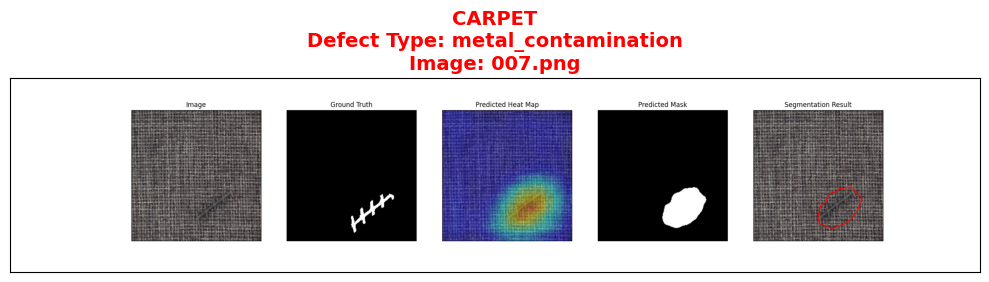

 carpet: metal_contamination - 007.png

 CATEGORY 2/3: PILL


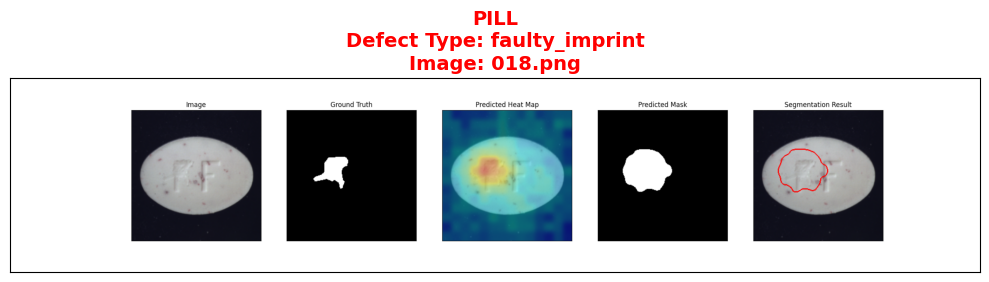

 pill: faulty_imprint - 018.png

 CATEGORY 3/3: GRID


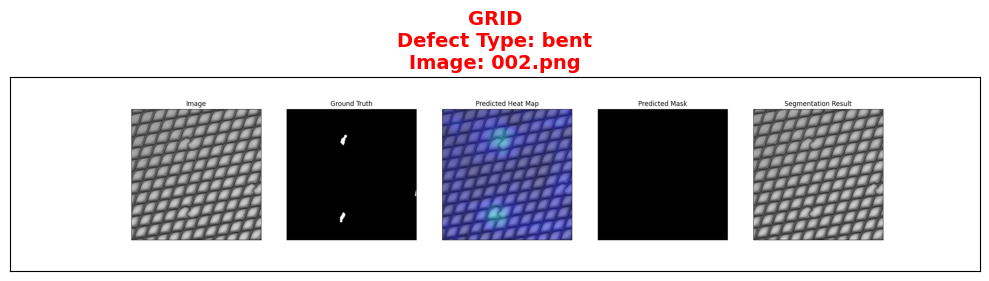

 grid: bent - 002.png


In [ ]:
import matplotlib.pyplot as plt
import glob
import cv2
import random
import os

def visualize_all_categories_results():
    """
    Display anomaly detection results for all 15 categories.
    Each category shows one defect image from the results folder.
    """

    MVTEC_CATEGORIES = [
        'bottle', 'cable', 'capsule', 'carpet', 'grid',
        'hazelnut', 'leather', 'metal_nut', 'pill', 'screw',
        'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
    ]

    print(f"\n{'='*80}")
    print(" ANOMALY DETECTION RESULTS - ALL 15 CATEGORIES")
    print(f"{'='*80}")

    for idx, category in enumerate(MVTEC_CATEGORIES):
        print(f"\n{'='*60}")
        print(f" CATEGORY {idx+1}/15: {category.upper()}")
        print(f"{'='*60}")

        # Possible paths for each category's results
        possible_paths = [
            os.path.join("/kaggle/working/results", "patchcore", "mvtec", category, 'run', 'images'),
            os.path.join("/kaggle/working/results", "patchcore", "mvtec", category, 'images'),
            os.path.join("/kaggle/working/results", category, 'images'),
            os.path.join("/kaggle/working/images", category),
            os.path.join("/kaggle/working", "visualization", category)
        ]

        defected_images = []
        images_path = None

        # Find the first existing path
        for path in possible_paths:
            if os.path.exists(path):
                images_path = path
                print(f" Found folder: {images_path}")
                break

        if images_path:
            try:
                # Collect all images
                all_images = []
                for ext in ['*.png', '*.jpg', '*.jpeg']:
                    all_images.extend(glob.glob(os.path.join(images_path, '**', ext), recursive=True))

                print(f" Found {len(all_images)} total images")

                # Filter defect images (exclude 'good')
                for img_path in all_images:
                    try:
                        path_parts = img_path.replace('\\', '/').split('/')
                        defect_type = path_parts[-2] if len(path_parts) > 2 else ''
                        if defect_type.lower() not in ['good', ''] and 'good' not in img_path.lower():
                            defected_images.append(img_path)
                    except Exception:
                        continue

                print(f"🔍 Filtered {len(defected_images)} defect images")

            except Exception as e:
                print(f" Error reading folder: {e}")
        else:
            print(f" No image folder found for {category}")

        # Display image or placeholder
        try:
            if defected_images:
                selected_image = random.choice(defected_images)
                img = cv2.imread(selected_image)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    defected_type = selected_image.replace('\\', '/').split('/')[-2]
                    image_name = os.path.basename(selected_image)

                    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
                    ax.imshow(img_rgb)
                    ax.set_title(f"{category.upper()}\nDefect Type: {defected_type}\nImage: {image_name}",
                                 fontsize=14, fontweight='bold', color='red')
                    ax.set_xticks([])
                    ax.set_yticks([])

                    plt.tight_layout()
                    plt.show()
                    plt.close()

                    print(f" Displayed defect image for {category}: {defected_type}")
                    print(f" Total defect images: {len(defected_images)}")
                    print(f" Selected image: {image_name}")
                else:
                    print(f" Cannot read image: {selected_image}")
                    raise Exception("Failed to read image")
            else:
                raise Exception("No defect images found")

        except Exception as e:
            # Display placeholder
            print(f"Error: {e}")
            fig, ax = plt.subplots(1, 1, figsize=(10, 8))
            ax.text(0.5, 0.5, f"{category.upper()}\nNo Defected Image Found\nin Results Folder",
                   ha='center', va='center', fontsize=16, color='red', fontweight='bold')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor('lightgray')

            plt.tight_layout()
            plt.show()
            plt.close()

            print(f" {category}: No defect images found")

def visualize_random_categories(num_categories: int = 5):
    """
    Display a random selection of categories.
    """
    MVTEC_CATEGORIES = [
        'bottle', 'cable', 'capsule', 'carpet', 'grid',
        'hazelnut', 'leather', 'metal_nut', 'pill', 'screw',
        'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
    ]

    selected_categories = random.sample(MVTEC_CATEGORIES, min(num_categories, len(MVTEC_CATEGORIES)))

    print(f"\n{'='*80}")
    print(f" DISPLAYING {len(selected_categories)} RANDOM CATEGORIES")
    print(f" Selected categories: {selected_categories}")
    print(f"{'='*80}")

    for idx, category in enumerate(selected_categories):
        print(f"\n{'='*60}")
        print(f" CATEGORY {idx+1}/{len(selected_categories)}: {category.upper()}")
        print(f"{'='*60}")

        possible_paths = [
            os.path.join("/kaggle/working/results", "patchcore", "mvtec", category, 'run', 'images'),
            os.path.join("/kaggle/working/results", "patchcore", "mvtec", category, 'images'),
            os.path.join("/kaggle/working/results", category, 'images'),
            os.path.join("/kaggle/working/images", category)
        ]

        defected_images = []
        images_path = None

        for path in possible_paths:
            if os.path.exists(path):
                images_path = path
                break

        if images_path:
            try:
                all_images = []
                for ext in ['*.png', '*.jpg', '*.jpeg']:
                    all_images.extend(glob.glob(os.path.join(images_path, '**', ext), recursive=True))

                for img_path in all_images:
                    try:
                        path_parts = img_path.replace('\\', '/').split('/')
                        defect_type = path_parts[-2] if len(path_parts) > 2 else ''
                        if defect_type.lower() not in ['good', ''] and 'good' not in img_path.lower():
                            defected_images.append(img_path)
                    except:
                        continue
            except Exception as e:
                print(f" Error reading images: {e}")

        try:
            if defected_images:
                selected_image = random.choice(defected_images)
                img = cv2.imread(selected_image)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    defected_type = selected_image.replace('\\', '/').split('/')[-2]
                    image_name = os.path.basename(selected_image)

                    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
                    ax.imshow(img_rgb)
                    ax.set_title(f"{category.upper()}\nDefect Type: {defected_type}\nImage: {image_name}",
                                 fontsize=14, fontweight='bold', color='red')
                    ax.set_xticks([])
                    ax.set_yticks([])

                    plt.tight_layout()
                    plt.show()
                    plt.close()

                    print(f" {category}: {defected_type} - {image_name}")
                else:
                    raise Exception("Failed to read image")
            else:
                raise Exception("No defect images found")
        except Exception as e:
            print(f" {category}: {e}")

def check_results_structure():
    """
    Check the structure of the results folder for debugging.
    """
    results_path = "/kaggle/working/results"

    print(f"\n{'='*80}")
    print(" CHECKING RESULTS FOLDER STRUCTURE")
    print(f"{'='*80}")

    if os.path.exists(results_path):
        print(f"✅ Results folder exists: {results_path}")
        try:
            subdirs = [d for d in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, d))]
            print(f"Subdirectories in results: {subdirs}")

            for subdir in subdirs[:3]:  # Only check first 3 subdirectories
                subdir_path = os.path.join(results_path, subdir)
                print(f"\n🔍 Checking {subdir}:")
                try:
                    items = os.listdir(subdir_path)
                    print(f"   Contents: {items}")
                    if 'mvtec' in items:
                        mvtec_path = os.path.join(subdir_path, 'mvtec')
                        if os.path.exists(mvtec_path):
                            categories = os.listdir(mvtec_path)
                            print(f"   Categories in mvtec: {categories[:5]}...")
                except Exception as e:
                    print(f"    Error reading folder: {e}")
        except Exception as e:
            print(f" Error accessing results folder: {e}")
    else:
        print(f" Results folder does not exist: {results_path}")
        print(" Checking alternative folders:")
        alternative_paths = [
            "/kaggle/working/images",
            "/kaggle/working/visualization",
            "/kaggle/working"
        ]
        for alt_path in alternative_paths:
            if os.path.exists(alt_path):
                try:
                    contents = os.listdir(alt_path)
                    print(f"📁 {alt_path}: {contents[:5]}...")
                except:
                    print(f" Cannot read {alt_path}")

# Run the functions safely
try:
    check_results_structure()

    print("\n" + "="*80)
    print("RUNNING VISUALIZATION FOR 3 RANDOM CATEGORIES:")
    print("="*80)
    visualize_random_categories(3)

    # Uncomment to visualize all categories (may take longer)
    # visualize_all_categories_results()

except Exception as e:
    print(f" Error during visualization: {e}")
    print(" Check dataset paths or ensure training was completed first")
